# Preparation

In [1]:
import numpy as np
# import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import matplotlib.widgets as widgets
import os

%matplotlib inline

cwd = os.getcwd()
CURRENT_DIR = os.path.dirname(cwd)

In [2]:
# batch_size = 16
# epoch = 1

# train, test = tf.keras.datasets.mnist.load_data()
# mnist_train_x, mnist_train_y = train
# mnist_test_x, mnist_test_y = test
# mnist_train_x = (mnist_train_x / 255) > 0.5 #* 2 - 1
# mnist_test_x = (mnist_test_x / 255) > 0.5 #* 2 - 1

# mnist_train_x = np.reshape(mnist_train_x, [-1, mnist_train_x.shape[1] * mnist_train_x.shape[2]])
# mnist_test_x = np.reshape(mnist_test_x, [-1, mnist_test_x.shape[1] * mnist_test_x.shape[2]])

# dataset_train = tf.data.Dataset.from_tensor_slices(mnist_train_x)
# dataset_train = dataset_train.shuffle(1000).repeat(epoch).batch(batch_size)
# iterator = dataset_train.make_one_shot_iterator()
# X = iterator.get_next()

# from tensorflow.examples.tutorials.mnist import input_data

# mnist = input_data.read_data_sets('../MNIST_data', one_hot=False, reshape=False)
# length = mnist.train.images.shape[1]
# X_dim = int(length**2)
# # y_dim = mnist.train.labels.shape[1]

import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist

# input image dimensions
img_rows, img_cols = 28, 28
num_classes = 10

# the data, split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [3]:
def down_sample_flatten(X, factor):
    return np.reshape(X[:, ::factor, ::factor, 0], [X.shape[0], -1])


# def reshape_flatten(X, size, interpolation=cv2.INTER_LINEAR):
#     N, H, W, _ = X.shape 
#     X = X.reshape([N, H, W])
#     X = X.transpose([1, 2, 0])
#     X = cv2.resize(X, dsize=(size, size), interpolation=interpolation)
#     return X.transpose([2, 0, 1]).reshape([N, -1])


def reshape_flatten(X, size):
    N, H, W, _ = X.shape 
    return X.reshape([N, -1])


def sigm(x, T=1, bipolar=True):
#     return np.tanh(x)
    y = 1/(1 + np.exp(-x/T))
    if bipolar:
        y = y * 2 - 1
    return y


def sample(x, inject_bernoulli=False, num_noise=4, mag_noise=0.1, bipolar=True):
   
    if inject_bernoulli:
        noise = np.random.binomial(n=1, p=0.5, size=(x.shape[0], x.shape[1], num_noise)) * 2 - 1
        noise = np.sum(noise, axis=2)
        noise = mag_noise * noise
        y = x + noise
        y = (y > 0).astype(np.float)
        if bipolar:
            y = y * 2 - 1
        return y
    
    if bipolar:
        x = (x + 1) / 2
        y = np.random.binomial(n=1, p=x)
        y = y * 2 - 1
        return y
    return np.random.binomial(n=1, p=x)


def infer(X, W, a, normalized=False, sigm_T=1, nonnegative=False, activated=True, bipolar=True, offset=0.0, quantize=False, num_levels=7):
    # mb_size x x_dim -> mb_size x h_dim
    W_eq = W
    a_eq = a
    if nonnegative:
        W_eq = np.maximum(W_eq, 0)
    if quantize:
        W_eq = quantize_uniform(W_eq, num_levels=num_levels)
    if normalized:
        norm = np.sum(np.abs(W), axis=0) + np.abs(a)
        W_eq = W_eq / norm
        a_eq = a / norm
    Y = X.dot(W_eq) + a_eq
    Y = Y + offset
    if activated:
        Y = sigm(Y, sigm_T, bipolar=bipolar)
    return Y


def generate(H, W, b, normalized=False, sigm_T=1, nonnegative=False, activated=True, bipolar=True, offset=0.0, quantize=False, num_levels=7):
    # mb_size x h_dim -> mb_size x x_dim
    W_eq = W
    b_eq = b
    if nonnegative:
        W_eq = np.maximum(W_eq, 0)
    if quantize:
        W_eq = quantize_uniform(W_eq, num_levels=num_levels)
    if normalized:
        norm = np.sum(np.abs(W), axis=1) + np.abs(b)
        W_eq = W_eq / norm.reshape([-1,1])
        b_eq = b_eq / norm
    Y = H.dot(W_eq.T) + b_eq
    Y = Y + offset
    if activated:
        Y = sigm(Y, sigm_T, bipolar=bipolar)
    return Y


def quantize_uniform(W, num_levels=7, clip=None):
    if clip is None:
        clip = 3 * W.std()
    bins = np.linspace(-clip, clip, num_levels+1)
    rep = np.linspace(-clip+clip/num_levels, clip-clip/num_levels, num_levels)
    idx = np.digitize(W, bins)
    idx[idx == 0] = 1
    idx[idx == num_levels+1] = num_levels
    W_quant = rep[idx-1]
    return W_quant
    

# X_val = (mnist.validation.next_batch(64)[0] > 0.5).astype(np.float)
# X_val = down_sample_flatten(X_val, downsample)
# X_val = X_val*2-1

In [4]:
def quantize_unsigned(x, num_bits, max_value):
    y = np.maximum(np.minimum(x, max_value), 0.0)
    y = np.round(y / max_value * (2**num_bits-1))
    return y


def quantize_unsigned_rescale(x, num_bits, max_value):
    return x / (2**num_bits-1) * max_value

def fake_quant_unsigned(x, num_bits, max_value=1.0):
    return quantize_unsigned_rescale(quantize_unsigned(x, num_bits, max_value), num_bits, max_value)

In [5]:
# Visualization
# -------------

def plot(samples, size, name):
    size = int(size)
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(size, size), cmap='Greys_r')
        
def plot_single(sample, size, name):
    size = int(size)
    fig = plt.figure(figsize=(4, 4))

    ax = plt.subplot(111)
    ax.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.spines['left'].set_visible(False)
    ax.imshow(sample.reshape(size, size), cmap='Greys_r', extent=[0,15,0,15])
    return (fig, ax)
        
def corrupt_lower(x, gray=0.0):
    x_c = np.copy(x)
    c_idx = int(length_d/3)*2 * length_d
    x_c[:, int(c_idx):] = gray
    return x_c

def corrupt_partial(x, loc='bottom', gray=0.0):
    x_c = np.copy(x)
    if loc == 'bottom':
        c_idx = int(length_d/3)*2 * length_d
        x_c[:, int(c_idx):] = gray
    elif loc == 'middle':
        x_c[:, int(length_d/3)*1 * length_d : int(length_d/3)*2 * length_d] = gray
    elif loc == 'top':
        x_c[:, :int(length_d/3)*1 * length_d] = gray
    return x_c


def recover_partial(x, x_target, loc='bottom'):
    if len(x.shape) == 1:
        if loc == 'bottom':
            c_idx = int(length_d/3)*2 * length_d
            x[:int(c_idx)] = x_target[:int(c_idx)]
        elif loc == 'middle':
            x[int(length_d/3)*2 * length_d: length_d**2] = x_target[int(length_d/3)*2 * length_d: length_d**2]
            x[:int(length_d/3)*1 * length_d] = x_target[:int(length_d/3)*1 * length_d]
        elif loc == 'top':
            x[int(length_d/3)*1 * length_d: length_d**2] = x_target[int(length_d/3)*1 * length_d: length_d**2]
    elif len(x.shape) == 2:
        if loc == 'bottom':
            c_idx = int(length_d/3)*2 * length_d
            x[:, :int(c_idx)] = x_target[:, :int(c_idx)]
        elif loc == 'middle':
            x[:, int(length_d/3)*2 * length_d:length_d**2] = x_target[:, int(length_d/3)*2 * length_d:length_d**2]
            x[:, :int(length_d/3)*1 * length_d] = x_target[:, :int(length_d/3)*1 * length_d]
        elif loc == 'top':
            x[:, int(length_d/3)*1 * length_d:length_d**2] = x_target[:, int(length_d/3)*1 * length_d:length_d**2]
    return x

def corrupt_random(x, p):
    x_c = np.copy(x)
    mask = np.random.binomial(n=1, p=p, size=x_c.shape).astype(bool)
    x_c[mask] = (x[mask] < 0.7).astype(np.float32)
    return (x_c, mask)


def recover_random(x, x_target, mask):
    x[:, :x_target.shape[1]][~mask] = x_target[~mask]
    return x

# Training

In [80]:
length_d = 28
LABEL = True
# imgs_tmp, y_tmp = mnist.train.next_batch(256)
imgs_tmp = X_train[:256, :, :, :]
y_tmp = y_train[:256, :]
imgs_d = reshape_flatten(imgs_tmp, length_d).astype(np.float)
if LABEL:
    imgs_d = np.concatenate([imgs_d, y_tmp], axis=1)
# imgs_b = (imgs_d > 0.3)
prob = np.mean(imgs_d, axis=0)
prob = 0.8*prob+0.1
log_prob = np.log10(prob / (1-prob))

In [105]:
LABEL = True
NORMALIZED = False
SIGM_T = 1
BIPOLAR = False
NONNEGATIVE = False
QUANTIZE = False
NUM_LEVELS = 7

length_d = 28 #int(np.ceil(length/downsample))
X_dim_d = int(length_d**2)
if LABEL:
    X_dim_d = X_dim_d + 10


epoch = 50
mb_size = 16
h_dim = 120
print_every = 100

K = 5  # Num. of Gibbs sampling step

# Contrastive Divergence

# iteration = int(60000 * epoch / mb_size)
step_per_epoch = int(60000 / mb_size)


for _ in range(1):
    lr = 0.001 #10**np.random.uniform(-3, -1)
    w_std = 0.01 #0.510179 #10**np.random.uniform(-1, 1)
    weight_decay = 1e-4
    clip_decay = 0.00000
    alpha = 0.9
    beta = 0.0
    
    W = np.random.randn(X_dim_d, h_dim) * w_std  # np.random.uniform(0, 0.01, [X_dim_d, h_dim])
    a = np.random.randn(h_dim) * w_std # -np.ones(h_dim) * w_std
    b = np.copy(log_prob) #np.random.randn(X_dim_d) * w_std
    w_max = 1.0
    
    v_W = np.zeros_like(W)
    v_a = np.zeros_like(a)
    v_b = np.zeros_like(b)
    v_w_max = 0
    
    recon_error = np.zeros(epoch * step_per_epoch)
    
    for e in range(epoch):
        if e == 0:
            alpha = 0.5
        else:
            alpha = 0.9
        for s in range(step_per_epoch):
            X_tmp = X_train[s*mb_size:(s+1)*mb_size, :, :, :]
            y_tmp = y_train[s*mb_size:(s+1)*mb_size, :]
    #         X_tmp, y_tmp = mnist.train.next_batch(mb_size)
            X_mb = reshape_flatten(X_tmp, length_d).astype(np.float)
            if LABEL:
                X_mb = np.concatenate([X_mb, y_tmp], axis=1)
            if BIPOLAR:
                X_mb = X_mb * 2 - 1

            W_clip = np.clip(W, -w_max, w_max)
            W_clip = W_clip + np.random.normal(scale=0.40, size=W.shape)
#             W_clip = W
#             W_clip = quantize_uniform(W, 15, w_max)

            # E[h|v,W]
            h = infer(X_mb, W_clip, a, normalized=NORMALIZED, nonnegative=NONNEGATIVE, sigm_T=SIGM_T, bipolar=BIPOLAR,
                      quantize=QUANTIZE, num_levels=NUM_LEVELS)

            # Gibbs sampling steps
            v_prime = np.copy(X_mb)

            for k in range(K):
                # h ~ p(h|v,W)
                h_prime = sample(infer(v_prime, W_clip, a, normalized=NORMALIZED, nonnegative=NONNEGATIVE, sigm_T=SIGM_T, bipolar=BIPOLAR,
                                      quantize=QUANTIZE, num_levels=NUM_LEVELS), 
                                 bipolar=BIPOLAR)
                # v ~ p(v|h,W)
                v_prime = generate(h_prime, W_clip, b, normalized=NORMALIZED, nonnegative=NONNEGATIVE, sigm_T=SIGM_T, bipolar=BIPOLAR,
                                  quantize=QUANTIZE, num_levels=NUM_LEVELS)
    #             v_prime = sample(v_prime)

            # E[h|v',W]
            h_prime = infer(v_prime, W_clip, a, normalized=NORMALIZED, nonnegative=NONNEGATIVE, sigm_T=SIGM_T, bipolar=BIPOLAR,
                           quantize=QUANTIZE, num_levels=NUM_LEVELS)

            err = np.linalg.norm(v_prime - X_mb) / mb_size
            recon_error[e*step_per_epoch+s] = err

            if s % print_every == 0:
                print('epoch: %d, step: %d, reconstruction error: %f' % (e, s, err))

            # Compute data gradient
            grad_w = (X_mb.T.dot(h) - v_prime.T.dot(h_prime)) / mb_size
    #         if NONNEGATIVE:
    #             grad_w = grad_w * (W > 0)
            grad_w = grad_w - (weight_decay * W) - (beta * np.minimum(W, 0))
            grad_a = np.mean(h - h_prime, axis=0) #- (weight_decay * a)
            grad_b = np.mean(X_mb - v_prime, axis=0) #- (weight_decay * b)
#             if epoch >= 10:
#                 grad_w_max = np.sum(grad_w * (W > w_max)) - np.sum(grad_w * (W < -w_max)) - clip_decay * w_max
#             else:
#                 grad_w_max = 0

            v_W = alpha * v_W + lr * grad_w
            v_a = alpha * v_a + lr * grad_a
            v_b = alpha * v_b + lr * grad_b
#             v_w_max = alpha * v_w_max + lr * grad_w_max

            # Update to maximize
            W += v_W
            a += v_a
            b += v_b
#             w_max += v_w_max
    

epoch: 0, step: 0, reconstruction error: 4.243097
epoch: 0, step: 100, reconstruction error: 3.053614
epoch: 0, step: 200, reconstruction error: 2.891190
epoch: 0, step: 300, reconstruction error: 2.704489
epoch: 0, step: 400, reconstruction error: 2.586236
epoch: 0, step: 500, reconstruction error: 2.574903
epoch: 0, step: 600, reconstruction error: 2.382792
epoch: 0, step: 700, reconstruction error: 2.395950
epoch: 0, step: 800, reconstruction error: 2.238415
epoch: 0, step: 900, reconstruction error: 2.268397
epoch: 0, step: 1000, reconstruction error: 2.167349
epoch: 0, step: 1100, reconstruction error: 2.278770
epoch: 0, step: 1200, reconstruction error: 2.243972
epoch: 0, step: 1300, reconstruction error: 2.199573
epoch: 0, step: 1400, reconstruction error: 2.192454
epoch: 0, step: 1500, reconstruction error: 2.208237
epoch: 0, step: 1600, reconstruction error: 2.078439
epoch: 0, step: 1700, reconstruction error: 2.169266
epoch: 0, step: 1800, reconstruction error: 2.111284
epoch

epoch: 4, step: 400, reconstruction error: 1.665837
epoch: 4, step: 500, reconstruction error: 1.832939
epoch: 4, step: 600, reconstruction error: 1.619740
epoch: 4, step: 700, reconstruction error: 1.563081
epoch: 4, step: 800, reconstruction error: 1.578413
epoch: 4, step: 900, reconstruction error: 1.617707
epoch: 4, step: 1000, reconstruction error: 1.539269
epoch: 4, step: 1100, reconstruction error: 1.728254
epoch: 4, step: 1200, reconstruction error: 1.767924
epoch: 4, step: 1300, reconstruction error: 1.582555
epoch: 4, step: 1400, reconstruction error: 1.635619
epoch: 4, step: 1500, reconstruction error: 1.624782
epoch: 4, step: 1600, reconstruction error: 1.555927
epoch: 4, step: 1700, reconstruction error: 1.615880
epoch: 4, step: 1800, reconstruction error: 1.647754
epoch: 4, step: 1900, reconstruction error: 1.640500
epoch: 4, step: 2000, reconstruction error: 1.712571
epoch: 4, step: 2100, reconstruction error: 1.595896
epoch: 4, step: 2200, reconstruction error: 1.638308

epoch: 8, step: 800, reconstruction error: 1.515657
epoch: 8, step: 900, reconstruction error: 1.542837
epoch: 8, step: 1000, reconstruction error: 1.463370
epoch: 8, step: 1100, reconstruction error: 1.690354
epoch: 8, step: 1200, reconstruction error: 1.717186
epoch: 8, step: 1300, reconstruction error: 1.499323
epoch: 8, step: 1400, reconstruction error: 1.601730
epoch: 8, step: 1500, reconstruction error: 1.590527
epoch: 8, step: 1600, reconstruction error: 1.497553
epoch: 8, step: 1700, reconstruction error: 1.592565
epoch: 8, step: 1800, reconstruction error: 1.571367
epoch: 8, step: 1900, reconstruction error: 1.585145
epoch: 8, step: 2000, reconstruction error: 1.682197
epoch: 8, step: 2100, reconstruction error: 1.547753
epoch: 8, step: 2200, reconstruction error: 1.606217
epoch: 8, step: 2300, reconstruction error: 1.630541
epoch: 8, step: 2400, reconstruction error: 1.620967
epoch: 8, step: 2500, reconstruction error: 1.485442
epoch: 8, step: 2600, reconstruction error: 1.51

epoch: 12, step: 1000, reconstruction error: 1.446261
epoch: 12, step: 1100, reconstruction error: 1.691880
epoch: 12, step: 1200, reconstruction error: 1.647209
epoch: 12, step: 1300, reconstruction error: 1.484832
epoch: 12, step: 1400, reconstruction error: 1.558384
epoch: 12, step: 1500, reconstruction error: 1.553104
epoch: 12, step: 1600, reconstruction error: 1.446921
epoch: 12, step: 1700, reconstruction error: 1.530620
epoch: 12, step: 1800, reconstruction error: 1.566094
epoch: 12, step: 1900, reconstruction error: 1.541939
epoch: 12, step: 2000, reconstruction error: 1.609054
epoch: 12, step: 2100, reconstruction error: 1.485239
epoch: 12, step: 2200, reconstruction error: 1.560673
epoch: 12, step: 2300, reconstruction error: 1.646517
epoch: 12, step: 2400, reconstruction error: 1.552899
epoch: 12, step: 2500, reconstruction error: 1.451634
epoch: 12, step: 2600, reconstruction error: 1.504720
epoch: 12, step: 2700, reconstruction error: 1.632117
epoch: 12, step: 2800, recon

epoch: 16, step: 1100, reconstruction error: 1.629334
epoch: 16, step: 1200, reconstruction error: 1.619748
epoch: 16, step: 1300, reconstruction error: 1.444303
epoch: 16, step: 1400, reconstruction error: 1.533684
epoch: 16, step: 1500, reconstruction error: 1.509691
epoch: 16, step: 1600, reconstruction error: 1.449693
epoch: 16, step: 1700, reconstruction error: 1.504986
epoch: 16, step: 1800, reconstruction error: 1.557914
epoch: 16, step: 1900, reconstruction error: 1.540718
epoch: 16, step: 2000, reconstruction error: 1.594391
epoch: 16, step: 2100, reconstruction error: 1.495136
epoch: 16, step: 2200, reconstruction error: 1.518930
epoch: 16, step: 2300, reconstruction error: 1.576896
epoch: 16, step: 2400, reconstruction error: 1.544615
epoch: 16, step: 2500, reconstruction error: 1.435202
epoch: 16, step: 2600, reconstruction error: 1.485367
epoch: 16, step: 2700, reconstruction error: 1.613715
epoch: 16, step: 2800, reconstruction error: 1.410512
epoch: 16, step: 2900, recon

epoch: 20, step: 1200, reconstruction error: 1.614214
epoch: 20, step: 1300, reconstruction error: 1.399688
epoch: 20, step: 1400, reconstruction error: 1.529106
epoch: 20, step: 1500, reconstruction error: 1.529447
epoch: 20, step: 1600, reconstruction error: 1.444823
epoch: 20, step: 1700, reconstruction error: 1.496593
epoch: 20, step: 1800, reconstruction error: 1.567753
epoch: 20, step: 1900, reconstruction error: 1.553961
epoch: 20, step: 2000, reconstruction error: 1.573597
epoch: 20, step: 2100, reconstruction error: 1.492576
epoch: 20, step: 2200, reconstruction error: 1.508475
epoch: 20, step: 2300, reconstruction error: 1.565904
epoch: 20, step: 2400, reconstruction error: 1.545809
epoch: 20, step: 2500, reconstruction error: 1.414494
epoch: 20, step: 2600, reconstruction error: 1.449773
epoch: 20, step: 2700, reconstruction error: 1.607018
epoch: 20, step: 2800, reconstruction error: 1.403756
epoch: 20, step: 2900, reconstruction error: 1.561429
epoch: 20, step: 3000, recon

epoch: 24, step: 1300, reconstruction error: 1.373876
epoch: 24, step: 1400, reconstruction error: 1.496876
epoch: 24, step: 1500, reconstruction error: 1.481311
epoch: 24, step: 1600, reconstruction error: 1.439786
epoch: 24, step: 1700, reconstruction error: 1.483762
epoch: 24, step: 1800, reconstruction error: 1.534933
epoch: 24, step: 1900, reconstruction error: 1.526260
epoch: 24, step: 2000, reconstruction error: 1.555235
epoch: 24, step: 2100, reconstruction error: 1.452357
epoch: 24, step: 2200, reconstruction error: 1.537015
epoch: 24, step: 2300, reconstruction error: 1.568326
epoch: 24, step: 2400, reconstruction error: 1.506833
epoch: 24, step: 2500, reconstruction error: 1.395284
epoch: 24, step: 2600, reconstruction error: 1.434439
epoch: 24, step: 2700, reconstruction error: 1.596231
epoch: 24, step: 2800, reconstruction error: 1.399700
epoch: 24, step: 2900, reconstruction error: 1.567980
epoch: 24, step: 3000, reconstruction error: 1.564487
epoch: 24, step: 3100, recon

epoch: 28, step: 1400, reconstruction error: 1.466236
epoch: 28, step: 1500, reconstruction error: 1.480118
epoch: 28, step: 1600, reconstruction error: 1.407797
epoch: 28, step: 1700, reconstruction error: 1.453480
epoch: 28, step: 1800, reconstruction error: 1.507646
epoch: 28, step: 1900, reconstruction error: 1.496409
epoch: 28, step: 2000, reconstruction error: 1.543659
epoch: 28, step: 2100, reconstruction error: 1.414925
epoch: 28, step: 2200, reconstruction error: 1.456865
epoch: 28, step: 2300, reconstruction error: 1.549147
epoch: 28, step: 2400, reconstruction error: 1.523178
epoch: 28, step: 2500, reconstruction error: 1.394719
epoch: 28, step: 2600, reconstruction error: 1.460291
epoch: 28, step: 2700, reconstruction error: 1.611405
epoch: 28, step: 2800, reconstruction error: 1.388877
epoch: 28, step: 2900, reconstruction error: 1.530093
epoch: 28, step: 3000, reconstruction error: 1.519337
epoch: 28, step: 3100, reconstruction error: 1.288004
epoch: 28, step: 3200, recon

epoch: 32, step: 1500, reconstruction error: 1.481894
epoch: 32, step: 1600, reconstruction error: 1.410730
epoch: 32, step: 1700, reconstruction error: 1.465472
epoch: 32, step: 1800, reconstruction error: 1.506630
epoch: 32, step: 1900, reconstruction error: 1.468193
epoch: 32, step: 2000, reconstruction error: 1.521818
epoch: 32, step: 2100, reconstruction error: 1.415000
epoch: 32, step: 2200, reconstruction error: 1.515542
epoch: 32, step: 2300, reconstruction error: 1.506022
epoch: 32, step: 2400, reconstruction error: 1.500126
epoch: 32, step: 2500, reconstruction error: 1.351665
epoch: 32, step: 2600, reconstruction error: 1.453885
epoch: 32, step: 2700, reconstruction error: 1.559313
epoch: 32, step: 2800, reconstruction error: 1.379168
epoch: 32, step: 2900, reconstruction error: 1.521777
epoch: 32, step: 3000, reconstruction error: 1.516384
epoch: 32, step: 3100, reconstruction error: 1.316603
epoch: 32, step: 3200, reconstruction error: 1.512832
epoch: 32, step: 3300, recon

epoch: 36, step: 1600, reconstruction error: 1.390976
epoch: 36, step: 1700, reconstruction error: 1.436287
epoch: 36, step: 1800, reconstruction error: 1.493589
epoch: 36, step: 1900, reconstruction error: 1.443857
epoch: 36, step: 2000, reconstruction error: 1.497904
epoch: 36, step: 2100, reconstruction error: 1.397661
epoch: 36, step: 2200, reconstruction error: 1.450793
epoch: 36, step: 2300, reconstruction error: 1.483766
epoch: 36, step: 2400, reconstruction error: 1.491034
epoch: 36, step: 2500, reconstruction error: 1.360930
epoch: 36, step: 2600, reconstruction error: 1.428751
epoch: 36, step: 2700, reconstruction error: 1.593549
epoch: 36, step: 2800, reconstruction error: 1.329616
epoch: 36, step: 2900, reconstruction error: 1.507932
epoch: 36, step: 3000, reconstruction error: 1.497764
epoch: 36, step: 3100, reconstruction error: 1.300484
epoch: 36, step: 3200, reconstruction error: 1.483456
epoch: 36, step: 3300, reconstruction error: 1.435681
epoch: 36, step: 3400, recon

epoch: 40, step: 1700, reconstruction error: 1.462602
epoch: 40, step: 1800, reconstruction error: 1.464512
epoch: 40, step: 1900, reconstruction error: 1.475752
epoch: 40, step: 2000, reconstruction error: 1.520384
epoch: 40, step: 2100, reconstruction error: 1.430282
epoch: 40, step: 2200, reconstruction error: 1.454668
epoch: 40, step: 2300, reconstruction error: 1.548233
epoch: 40, step: 2400, reconstruction error: 1.464545
epoch: 40, step: 2500, reconstruction error: 1.371292
epoch: 40, step: 2600, reconstruction error: 1.415644
epoch: 40, step: 2700, reconstruction error: 1.570072
epoch: 40, step: 2800, reconstruction error: 1.326634
epoch: 40, step: 2900, reconstruction error: 1.484102
epoch: 40, step: 3000, reconstruction error: 1.503727
epoch: 40, step: 3100, reconstruction error: 1.287218
epoch: 40, step: 3200, reconstruction error: 1.475415
epoch: 40, step: 3300, reconstruction error: 1.415738
epoch: 40, step: 3400, reconstruction error: 1.499522
epoch: 40, step: 3500, recon

epoch: 44, step: 1800, reconstruction error: 1.476109
epoch: 44, step: 1900, reconstruction error: 1.450436
epoch: 44, step: 2000, reconstruction error: 1.489790
epoch: 44, step: 2100, reconstruction error: 1.375493
epoch: 44, step: 2200, reconstruction error: 1.407616
epoch: 44, step: 2300, reconstruction error: 1.489834
epoch: 44, step: 2400, reconstruction error: 1.470739
epoch: 44, step: 2500, reconstruction error: 1.365984
epoch: 44, step: 2600, reconstruction error: 1.389999
epoch: 44, step: 2700, reconstruction error: 1.534668
epoch: 44, step: 2800, reconstruction error: 1.296458
epoch: 44, step: 2900, reconstruction error: 1.495024
epoch: 44, step: 3000, reconstruction error: 1.500262
epoch: 44, step: 3100, reconstruction error: 1.293261
epoch: 44, step: 3200, reconstruction error: 1.458591
epoch: 44, step: 3300, reconstruction error: 1.398449
epoch: 44, step: 3400, reconstruction error: 1.451576
epoch: 44, step: 3500, reconstruction error: 1.445830
epoch: 44, step: 3600, recon

epoch: 48, step: 1900, reconstruction error: 1.442015
epoch: 48, step: 2000, reconstruction error: 1.501426
epoch: 48, step: 2100, reconstruction error: 1.374510
epoch: 48, step: 2200, reconstruction error: 1.458127
epoch: 48, step: 2300, reconstruction error: 1.451872
epoch: 48, step: 2400, reconstruction error: 1.459314
epoch: 48, step: 2500, reconstruction error: 1.354828
epoch: 48, step: 2600, reconstruction error: 1.420666
epoch: 48, step: 2700, reconstruction error: 1.550110
epoch: 48, step: 2800, reconstruction error: 1.323292
epoch: 48, step: 2900, reconstruction error: 1.517281
epoch: 48, step: 3000, reconstruction error: 1.504824
epoch: 48, step: 3100, reconstruction error: 1.272931
epoch: 48, step: 3200, reconstruction error: 1.458851
epoch: 48, step: 3300, reconstruction error: 1.417778
epoch: 48, step: 3400, reconstruction error: 1.459221
epoch: 48, step: 3500, reconstruction error: 1.438862
epoch: 48, step: 3600, reconstruction error: 1.402240
epoch: 48, step: 3700, recon

In [106]:
np.savez('rbm_checkpoints/v794_h120_label_50epoch_weight_decay_1e-4_momemtum_clip_fix_grad_wnoise0.40.npz', W=W, a=a, b=b, w_max=w_max)

In [107]:
np.save('rbm_checkpoints/v794_h120_label_100epoch_weight_decay_1e-4_momemtum_clip_fix_grad_wnoise0.40_error.npy', recon_error)

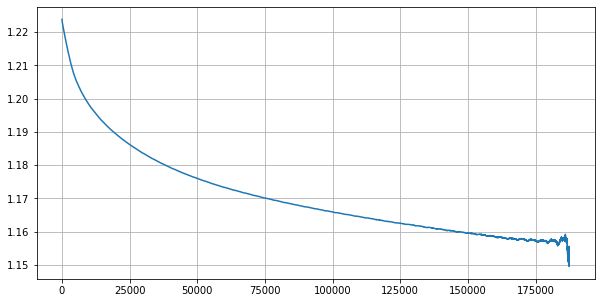

In [211]:
plt.figure(figsize=(10,5))
# plt.plot(recon_error)
plt.plot(moving_average(recon_error))
plt.grid()

In [209]:
def moving_average(x, window_length=100):
    length = len(x)-window_length+1
    y = np.zeros(length)
    for i in range(length):
        y[i] = np.mean(x[i:i+length])
    return y

# Evaluation

In [192]:
tmp = np.load('rbm_checkpoints//v794_h120_label_50epoch_weight_decay_1e-4_momemtum_clip_fix_grad_wnoise0.40.npz')
W = tmp['W']
a = tmp['a']
b = tmp['b']
w_max = tmp['w_max']

In [193]:
W = np.clip(W, -w_max, w_max)
# W = quantize_uniform(W, 15, w_max)
W_orig = np.copy(W)

In [194]:
a = np.clip(a, -16, 16)

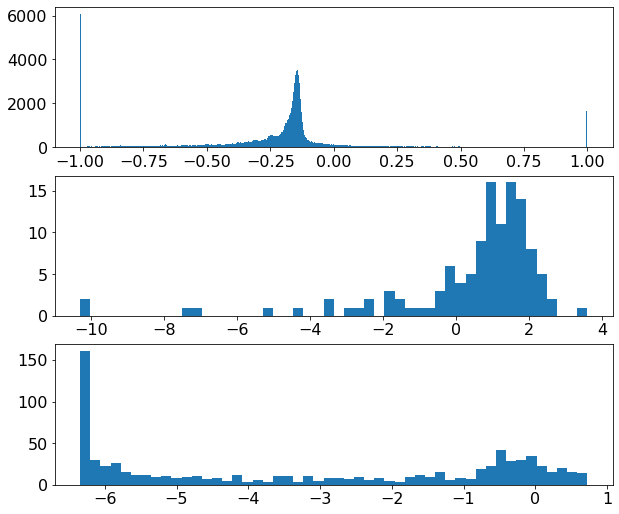

In [195]:
plt.figure(figsize=(10,15))

plt.subplot(5,1,1)
bins = 500 #np.linspace(-0.1, 0.1, 100)
h = plt.hist(W.flatten(), bins, label='W')
# plt.xlim(-3.5, 3.5)
# plt.xticks(np.arange(-10, 11, 1))
plt.subplot(5,1,2)
h = plt.hist(a.flatten(), 50, label='a')
plt.subplot(5,1,3)
h = plt.hist(b.flatten(), 50, label='b')
# plt.subplot(5,1,4)
# h = plt.hist(np.sum(np.abs(W), axis=0), 50)
# plt.subplot(5,1,5)
# h = plt.hist(np.sum(np.abs(W), axis=1), 50)

In [1064]:
W[W > 20] = 20
W[W < -20] = -20
W[np.abs(W) < 0.1] = 0

Test accuracy is 1.000000
Reconstruction error is 3.456026


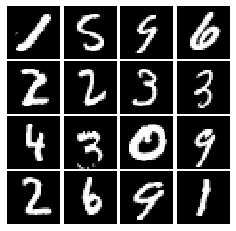

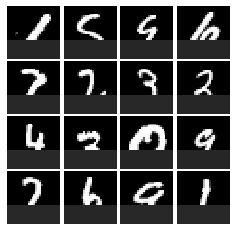

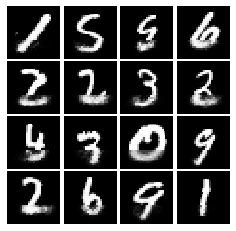

In [209]:
mb_size=10000
GIBBS_STEPS = 10
LABEL = True
SIGM_T = 1.0
BIPOLAR = False
NORMALIZED = False
NONNEGATIVE = False
CORRUPT_PART = 'bottom'
RESTART = True
WEIGHT_NOISE = 0.20
WEIGHT_QUANTIZE = False
WEIGHT_NUM_LEVELS = 7
SAMPLE_VISIBLE = True
DETERMINISTIC_SAMPLE = False
VISIBLE_QUANTIZE = True
VISIBLE_BITS = 3
INJECT_NOISE = False
FIX_LABEL = True
RECOVER = True

length_d = 28
X_dim_d = int(length_d**2)
if LABEL:
    X_dim_d = X_dim_d + 10

if WEIGHT_NOISE is None:
    W = W_orig
else:
    W = W_orig + np.random.normal(scale=WEIGHT_NOISE, size=W.shape)
    
if RESTART:
    if RECOVER:
        idx = np.random.choice(np.arange(X_test.shape[0]), size=mb_size, replace=False)
        X_mb = X_test[idx, :, :, :]
        y_mb = y_test[idx, :]
        X_mb = (reshape_flatten(X_mb, length_d)).astype(np.float)
        plot(X_mb[:16], length_d, 'V')
        if CORRUPT_PART == 'random':
            V, mask = corrupt_random(X_mb, 0.2)
        else:
            V = corrupt_partial(X_mb, loc=CORRUPT_PART, gray=np.mean(X_mb))
    else:
        V = np.random.binomial(n=1, p=0.5, size=[16, length_d**2])
        
    plot(V[:16], length_d, 'V_corrupted')    
    if LABEL:
        if FIX_LABEL:
            label_vector = y_mb
        else:
            label_vector = 0.1 * np.ones([mb_size, 10])
        V = np.concatenate([V, label_vector], axis=1)


errors = np.zeros(GIBBS_STEPS)
        
for g in range(GIBBS_STEPS):
    if SAMPLE_VISIBLE:
        if DETERMINISTIC_SAMPLE:
            V = (V > 0.5).astype(np.float64)
        else:
            V = sample(V, INJECT_NOISE, 4, 0.02, bipolar=BIPOLAR).astype(np.float64)
    if VISIBLE_QUANTIZE:
        V = fake_quant_unsigned(V, VISIBLE_BITS)
    H = infer(V, W, a, normalized=NORMALIZED, nonnegative=NONNEGATIVE, sigm_T=SIGM_T, activated=not INJECT_NOISE, bipolar=BIPOLAR,
             quantize=WEIGHT_QUANTIZE, num_levels=WEIGHT_NUM_LEVELS)
    if DETERMINISTIC_SAMPLE:
        H = (H > 0.5).astype(np.float64)
    else:
        H = sample(H, INJECT_NOISE, 8, 0.03, bipolar=BIPOLAR)

    V = generate(H, W, b, normalized=NORMALIZED, nonnegative=NONNEGATIVE, sigm_T=SIGM_T, activated=not INJECT_NOISE, bipolar=BIPOLAR,
                 offset=0.0, quantize=WEIGHT_QUANTIZE, num_levels=WEIGHT_NUM_LEVELS)

    if RECOVER:
        if CORRUPT_PART == 'random':
             V = recover_random(V, X_mb, mask)
        else:
            V = recover_partial(V, X_mb, loc=CORRUPT_PART)
    if FIX_LABEL:
        V[:, int(length_d**2):] = y_mb
        
    errors[g] = np.mean(np.linalg.norm(V[:,:int(length_d**2)] - X_mb, axis=1))

if LABEL:
    class_pred = np.argmax(V[:, X_dim_d-10:], axis=1)
#     print(class_pred)
    correct_pred = np.argmax(y_mb, axis=1)
    test_acc = np.sum(class_pred == correct_pred) / float(correct_pred.size)
    print('Test accuracy is %f' % test_acc)
#     V = V[:,:int(length_d**2)]

err = np.mean(np.linalg.norm(V[:,:int(length_d**2)] - X_mb, axis=1))
print('Reconstruction error is %f' % err)
plot(V[:16,:int(length_d**2)], length_d, 'V')

In [112]:
# errors_noises = []
errors_noises.append(errors)

In [126]:
for i, errors in enumerate(errors_noises):
    errors_noises[i] = np.insert(errors, 0, 12.198558)

In [128]:
np.save('errors_inference_0.1_noise_train_00-40', errors_noises)

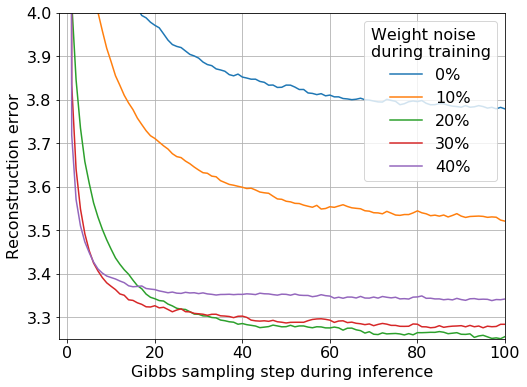

In [144]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(8, 6))
for n, e in enumerate(errors_noises):
    if n % 2 == 0:
        plt.plot(e, label="{0:.0%}".format(n * 0.05))
plt.legend(title='Weight noise\nduring training')
plt.xlim(-2, 100)
plt.ylim(3.25, 4)
plt.xlabel('Gibbs sampling step during inference')
plt.ylabel('Reconstruction error')
plt.grid()